In [28]:
# Standard libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Handeling .wav files

import librosa
from librosa import feature

# Machine Learning

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from functools import reduce

# data vizualisation

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
def merge_pd(machine):
    
    # Opening the .csv files
    
    df_6dB=pd.read_csv(f'Librosa_features_{machine}_6dB.csv')
    df_0dB=pd.read_csv(f'Librosa_features_{machine}_0dB.csv')
    df_min6dB=pd.read_csv(f'Librosa_features_{machine}_-6dB.csv')
    
    # Dropping the 'Unnamed: 0' column
    
    df_6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_0dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_min6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    

    
    # Merging the .csv files into one DataFrame
    
    data_frames = [df_6dB, df_0dB, df_min6dB]
    df_merged = pd.concat(data_frames)
    
    
    return df_merged

In [30]:
pump = merge_pd('pump')

In [31]:
minority_class_len = len(pump[pump['normal(0)/abnormal(1)'] == 1])
majority_class_indices = pump[pump['normal(0)/abnormal(1)'] == 0].index
random_majority_indices = np.random.choice(majority_class_indices, minority_class_len , replace= False)
minority_class_indices  = pump[pump['normal(0)/abnormal(1)'] == 1].index

under_sample_indices = np.concatenate( [minority_class_indices , random_majority_indices])
under_sample = pump.loc[under_sample_indices]
X = under_sample.drop(columns = ['normal(0)/abnormal(1)'])
y = under_sample['normal(0)/abnormal(1)']

# 20% of the overal data will seperated for later validation of the model

X_model, X_valid, y_model, y_valid = train_test_split(X, y, test_size=0.3, random_state = 42, stratify = y)

# 60% of the overal data (75% of X_model, y_model) will be used to create a training set for the model
# 20% of the overal data (25% of X_model, y_model) will be used to create a testing set for the model

X_train, X_test, y_train, y_test = train_test_split(X_model,
                                                   y_model,
                                                   test_size = 1/3,
                                                   random_state = 10, stratify=y_model)

In [32]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', SVC())])

In [33]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 56em; }</style>"))

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.feature_selection import RFE

y_pred = []
clfs = []

clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())

for index in range(1,len(X_train.columns)):
    
    for classifier in clfs:
        
        print("----------------------------------------------")
        print("----------------------------------------------")
        print(classifier)
        print("----------------------------------------------")
        print("----------------------------------------------")
        
        sel = RFE(classifier, n_features_to_select = index)
        sel.fit(X_train, y_train)
        features = X_train.columns[sel.get_support()]
        X_train_rfe = sel.transform(X_train)
        X_test_rfe = sel.transform(X_test)
        print('Selected Feature', index)
        print(features)
    
        classifier.fit(X_train_rfe, y_train)
        y_pred= classifier.predict(X_test_rfe)
        scores = cross_val_score(pipeline, X_train_rfe, y_train, cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1))


        print("----------------------------------------------")
        print("TRAIN-TEST")
        print("----------------------------------------------")


        print('confusion matrix', classifier)
        print(confusion_matrix(y_test, y_pred))
        print('classification report')
        print(classification_report(y_test, y_pred))
        print('accuracy score')
        print(accuracy_score(y_test, y_pred))
        
        X_valid_rfe = sel.transform(X_valid)
        y_pred = classifier.predict(X_valid_rfe)

        print("----------------------------------------------")
        print("TRAIN-VALIDATION")
        print("----------------------------------------------")

        print('confusion matrix', classifier)
        print(confusion_matrix(y_valid, y_pred))
        print('classification report')
        print(classification_report(y_valid, y_pred))
        print('accuracy score')
        print(accuracy_score(y_valid, y_pred))

----------------------------------------------
----------------------------------------------
DecisionTreeClassifier()
----------------------------------------------
----------------------------------------------
Selected Feature 1
Index(['max perc'], dtype='object')
----------------------------------------------
TRAIN-TEST
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[678 279]
 [125 833]]
classification report
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       957
           1       0.75      0.87      0.80       958

    accuracy                           0.79      1915
   macro avg       0.80      0.79      0.79      1915
weighted avg       0.80      0.79      0.79      1915

accuracy score
0.7890339425587467
----------------------------------------------
TRAIN-VALIDATION
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[ 867  365]
 [ 151 1080]]

Selected Feature 4
Index(['spectral_bandwidth', 'zero_crossing_rate', 'max perc', 'min harm'], dtype='object')
----------------------------------------------
TRAIN-TEST
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[810 147]
 [ 67 891]]
classification report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       957
           1       0.86      0.93      0.89       958

    accuracy                           0.89      1915
   macro avg       0.89      0.89      0.89      1915
weighted avg       0.89      0.89      0.89      1915

accuracy score
0.8882506527415144
----------------------------------------------
TRAIN-VALIDATION
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[1030  202]
 [  86 1145]]
classification report
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1232
           1       0.85  

Selected Feature 7
Index(['melspectrogram_corr', 'rms', 'spectral_bandwidth', 'spectral_contrast',
       'zero_crossing_rate', 'max harm', 'max perc'],
      dtype='object')
----------------------------------------------
TRAIN-TEST
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[828 129]
 [ 61 897]]
classification report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       957
           1       0.87      0.94      0.90       958

    accuracy                           0.90      1915
   macro avg       0.90      0.90      0.90      1915
weighted avg       0.90      0.90      0.90      1915

accuracy score
0.9007832898172323
----------------------------------------------
TRAIN-VALIDATION
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[1055  177]
 [  71 1160]]
classification report
              precision    recall  f1-score   support

           0   

Selected Feature 10
Index(['melspectrogram', 'melspectrogram_corr', 'rms', 'spectral_bandwidth',
       'spectral_contrast', 'zero_crossing_rate', 'max harm', 'max perc',
       'min harm', 'min perc'],
      dtype='object')
----------------------------------------------
TRAIN-TEST
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[804 153]
 [ 60 898]]
classification report
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       957
           1       0.85      0.94      0.89       958

    accuracy                           0.89      1915
   macro avg       0.89      0.89      0.89      1915
weighted avg       0.89      0.89      0.89      1915

accuracy score
0.8887728459530027
----------------------------------------------
TRAIN-VALIDATION
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[1052  180]
 [  66 1165]]
classification report
              precis

Selected Feature 13
Index(['melspectrogram_sum', 'melspectrogram_corr', 'mfcc', 'rms',
       'spectral_bandwidth', 'spectral_contrast', 'spectral_flatness ',
       'zero_crossing_rate', 'mean perc', 'max harm', 'max perc', 'min harm',
       'min perc'],
      dtype='object')
----------------------------------------------
TRAIN-TEST
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[820 137]
 [ 57 901]]
classification report
              precision    recall  f1-score   support

           0       0.94      0.86      0.89       957
           1       0.87      0.94      0.90       958

    accuracy                           0.90      1915
   macro avg       0.90      0.90      0.90      1915
weighted avg       0.90      0.90      0.90      1915

accuracy score
0.8986945169712793
----------------------------------------------
TRAIN-VALIDATION
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[1051  181]
 [

----------------------------------------------
TRAIN-TEST
----------------------------------------------
confusion matrix RandomForestClassifier()
[[901  56]
 [ 57 901]]
classification report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       957
           1       0.94      0.94      0.94       958

    accuracy                           0.94      1915
   macro avg       0.94      0.94      0.94      1915
weighted avg       0.94      0.94      0.94      1915

accuracy score
0.9409921671018276
----------------------------------------------
TRAIN-VALIDATION
----------------------------------------------
confusion matrix RandomForestClassifier()
[[1149   83]
 [  60 1171]]
classification report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1232
           1       0.93      0.95      0.94      1231

    accuracy                           0.94      2463
   macro avg       0.94    

----------------------------------------------
TRAIN-TEST
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[809 148]
 [ 66 892]]
classification report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       957
           1       0.86      0.93      0.89       958

    accuracy                           0.89      1915
   macro avg       0.89      0.89      0.89      1915
weighted avg       0.89      0.89      0.89      1915

accuracy score
0.8882506527415144
----------------------------------------------
TRAIN-VALIDATION
----------------------------------------------
confusion matrix DecisionTreeClassifier()
[[1028  204]
 [  87 1144]]
classification report
              precision    recall  f1-score   support

           0       0.92      0.83      0.88      1232
           1       0.85      0.93      0.89      1231

    accuracy                           0.88      2463
   macro avg       0.89    

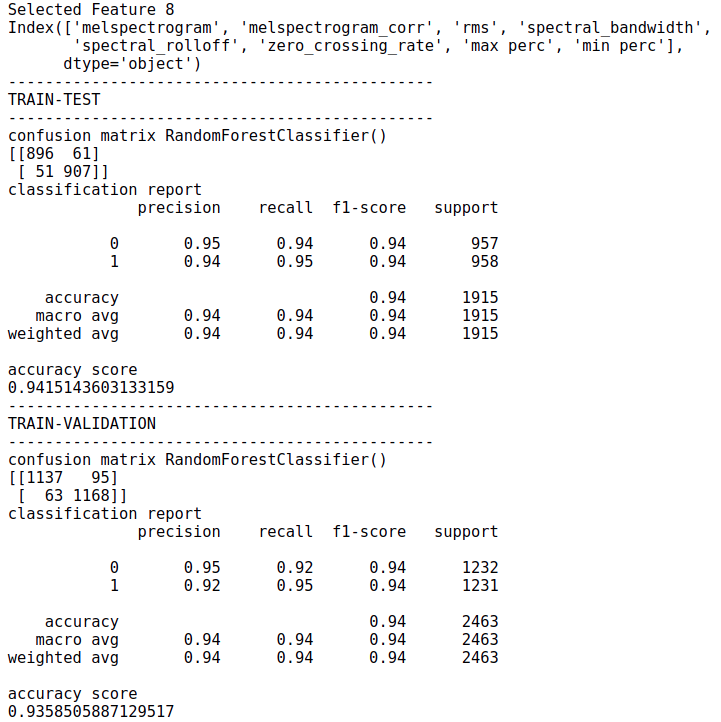